In [4]:
cache_len = torch.tensor([2,5,2,8])
cur_lens = torch.tensor([5,2,5,7])
total_len = cache_lens + cur_lens
print(total_len)

NameError: name 'torch' is not defined

In [5]:
causal_mask.shape

NameError: name 'causal_mask' is not defined

In [6]:
torch.arange(causal_mask.shape[0])[None].T

NameError: name 'torch' is not defined

In [7]:
(cache_lens[:,None,None] + torch.arange(cur_lens.max())[None,:,None]).shape

NameError: name 'cache_lens' is not defined

In [ ]:
torch.arange(total_len.max())[None,None,:]

torch.Size([1, 1, 15])

In [8]:
print(total_len, cur_lens, cache_len)

NameError: name 'total_len' is not defined

In [9]:
causal_mask = repeat(torch.arange(total_len.max()), 'i -> b r i', b=len(total_len), r=cur_lens.max())
causal_mask = causal_mask >= (cache_lens[:,None,None] + torch.arange(cur_lens.max())[None,:,None] + 1)
causal_mask[-3,0]


NameError: name 'repeat' is not defined

In [ ]:
causal_mask = torch.arange(total_len.max()).expand(len(total_len), -1)
causal_mask = causal_mask > cache_len[:,None]
causal_mask = causal_mask < torch.arange(causal_mask.shape[0])[None].T + cache_len[:,None] 

In [ ]:
torch.arange(causal_mask.shape[0])[None].T + cache_len[:,None] 

tensor([[ 2],
        [ 6],
        [ 4],
        [11]])

In [630]:
x_len = torch.tensor([7,6,4])
cache_len = torch.tensor([6,7,9])
total_len = x_len + cache_len
print(total_len)

tensor([13, 13, 13])


In [631]:
causal_mask = repeat(torch.arange(total_len.max()), 'i -> b r i', b=len(total_len), r=x_len.max())
cache_offset = cache_len[:,None,None] 
diagonal_offset = torch.arange(x_len.max())[None,:,None]
positional_grid = causal_mask - cache_offset - diagonal_offset # used for positional bias

In [632]:
positional_grid.shape

torch.Size([3, 7, 13])

In [633]:
positional_grid[2]*-1

tensor([[ 9,  8,  7,  6,  5,  4,  3,  2,  1,  0, -1, -2, -3],
        [10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0, -1, -2],
        [11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0, -1],
        [12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0],
        [13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1],
        [14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2],
        [15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3]])

In [634]:
x_len[:,None,None].shape

torch.Size([3, 1, 1])

In [635]:
(total_len-cache_len-1).max()[None,None,None]

tensor([[[6]]])

In [903]:
positional_grid[0]

tensor([[ -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6],
        [ -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5],
        [ -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4],
        [ -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2],
        [-11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1],
        [-12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0]])

In [908]:
pos[((positional_grid*-1) + (total_len-cache_len-1).max())].shape

torch.Size([3, 7, 13, 1])

In [468]:
indices, indices_p = pos(i=7, j=13, device='cpu', dtype=torch.float32)

In [964]:
i,j = 7,13
indices = ((positional_grid*-1) + (total_len-cache_len-1).max())
pos = torch.arange(positional_grid.min(), positional_grid.max()+1).flip(0)[:,None]
dpos = DynamicPositionBias(dim=64, depth=2, heads=1, activation=nn.SiLU)(pos=pos, indices=indices, dtype=torch.float32, device='cpu').detach()
print(dpos.shape)

torch.Size([3, 1, 7, 13])


In [989]:
with open('pos.pkl', 'rb') as f:
    pos = pkl.load(f)

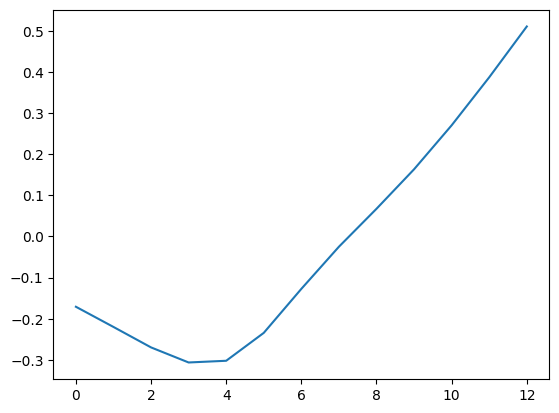

In [1004]:
dpos = DynamicPositionBias(dim=64, depth=2, heads=1, activation=nn.SiLU)
poos = dpos(pos=pos['pos'], indices=pos['positional_indices'], dtype=torch.float32, device='cpu').detach()
poos.shape
plt.plot(poos[0,0,0])

In [990]:
pos

dict_keys(['pos', 'positional_indices'])

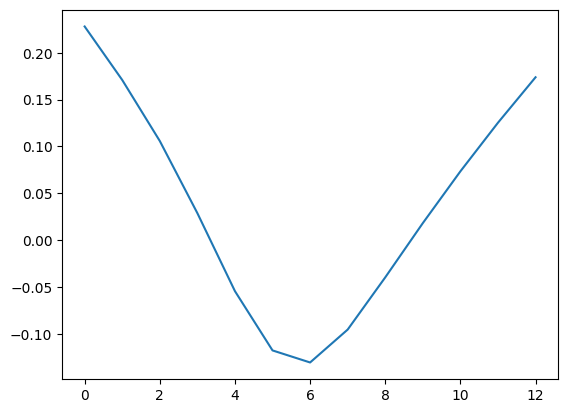

In [965]:
plt.plot(dpos[0,0,0])

In [1189]:
def pickleit(obj, path):
    import pickle as pkl
    with open(path, 'wb') as f:
        pkl.dump(obj, f)

def loadit(path):
    import pickle as pkl
    with open(path, 'rb') as f:
        return pkl.load(f)

In [1190]:
import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np
from einops import rearrange, repeat
from torch import einsum
from torch.utils.checkpoint import checkpoint # # gradient/activation checkpointing
from functools import partial
from typing import Dict, List, Optional, Tuple, Union

GLOBAL_NUM = 0

def exists(val):
    return val is not None

# token shifting
# lucidrains implementation: https://github.com/lucidrains/x-transformers/blob/main/x_transformers/x_transformers.py
# BlinkDL idea from RWKV-LM https://github.com/BlinkDL/RWKV-LM
def shift(t, amount, mask = None):
    if amount == 0:
        return t
    else:
        amount = min(amount, t.shape[1])

    if exists(mask):
        t = t.masked_fill(~mask[..., None], 0.)

    return F.pad(t, (0, 0, amount, -amount), value = 0.)

class ShiftTokens(nn.Module):
    def __init__(self, shifts, fn):
        super().__init__()
        self.fn = fn
        self.shifts = tuple(shifts)

    def forward(self, x, **kwargs):
        mask = kwargs.get('mask', None)
        shifts = self.shifts
        segments = len(shifts)
        feats_per_shift = x.shape[-1] // segments
        splitted = x.split(feats_per_shift, dim = -1)
        segments_to_shift, rest = splitted[:segments], splitted[segments:]
        segments_to_shift = list(map(lambda args: shift(*args, mask = mask), zip(segments_to_shift, shifts)))
        x = torch.cat((*segments_to_shift, *rest), dim = -1)
        return self.fn(x, **kwargs)


class DynamicPositionBias(nn.Module):
    def __init__(self, dim, *, heads, depth, log_distance = False, norm = False, activation=nn.SiLU):
        super().__init__()
        assert depth >= 1, 'depth for dynamic position bias MLP must be greater or equal to 1'
        self.log_distance = log_distance

        self.mlp = nn.ModuleList([])

        self.mlp.append(nn.Sequential(
            nn.Linear(1, dim),
            nn.LayerNorm(dim) if norm else nn.Identity(),
            activation()
        ))

        for _ in range(depth - 1):
            self.mlp.append(nn.Sequential(
                nn.Linear(dim, dim),
                nn.LayerNorm(dim) if norm else nn.Identity(),
                activation()
            ))

        self.mlp.append(nn.Linear(dim, heads))


    def forward(self, pos, indices, device, dtype):
        pos = pos.to(device=device, dtype=dtype)
        
        if self.log_distance:
            pos = torch.sign(pos) * torch.log(pos.abs() + 1)  # log of distance is sign(rel_pos) * log(abs(rel_pos) + 1)

        for layer in self.mlp:
            pos = layer(pos) 
      
        bias = pos[indices]
        #print(bias.shape)
        bias = rearrange(bias, 'b i j h -> b h i j')
        return bias

class ScaledSinuEmbedding(nn.Module):
    '''taken From Phil Wang's x-transformers library'''
    def __init__(self, dim):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(1,))
        inv_freq = 1. / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, x):
        n, device = x.shape[1], x.device
        t = torch.arange(n, device = device).type_as(self.inv_freq)
        sinu = einsum('i , j -> i j', t, self.inv_freq)
        emb = torch.cat((sinu.sin(), sinu.cos()), dim = -1)
        return emb * self.scale

class ReLUSquared(nn.Module):
    def forward(self, x):
        return torch.pow(F.relu(x), 2)

def l2norm(t, groups = 1, dim = -1):
    if groups == 1:
        return F.normalize(t, p = 2, dim = dim)
    t = rearrange(t, '... (g d) -> ... g d', g = groups)
    t = F.normalize(t, p = 2, dim = dim)
    return rearrange(t, '... g d -> ... (g d)')

class CosineAttention(nn.Module):
    def __init__(
        self,
        n_feats,
        head_dim,
        n_heads,
        dropout=0.1,
        bias=False,
        temperature=15.5,
        return_attention=False,
        causal=False,
        activation='softmax',
        **kwargs
    ):
        super().__init__()
        assert activation in ['relusq', 'softmax']
        self.shared_kv = kwargs.get('shared_kv', False)
        self.talking_heads = kwargs.get('talking_heads', False)

        self.n_feats, self.head_dim, self.n_heads = n_feats, head_dim, n_heads
        self.dropout = nn.Dropout(dropout)
        self.bias = bias
        self.return_attention = return_attention
        self.causal = causal

        if self.talking_heads:
            self._head_proj = nn.Conv2d(n_heads, n_heads, (1, 1))

        self.temperature = torch.nn.Parameter(torch.tensor(temperature), requires_grad=True) if isinstance(temperature, float) else temperature

        self.activation = ReLUSquared() if activation == 'relusq' else nn.Softmax(dim=-1)

        if not self.shared_kv:
            self.qkv_proj = nn.Linear(n_feats, 3 * n_heads * head_dim, bias=bias)
            self.qkv = lambda x: rearrange(self.qkv_proj(x), "b n (h d qkv) -> qkv b h n d", qkv=3, h=n_heads, d=head_dim)
        else:
            self.q_proj, self.kv_proj = [nn.Linear(n_feats, el, bias=bias) for el in [n_heads * head_dim, 2 * head_dim]]
            map_q, map_kv = lambda q: rearrange(q, 'b n (h d) -> b h n d', h=n_heads), lambda kv: rearrange(kv, 'b n (kv d) -> kv b () n d', kv=2, d=head_dim)
            self.qkv = lambda x: (map_q(self.q_proj(x)), *map_kv(self.kv_proj(x)))

        self.out_proj = nn.Linear(n_heads * head_dim, n_feats, bias=bias)
    
    def head_proj(self, dots):
        if not self.talking_heads:
            return dots
        dots = self._head_proj(dots)
        return dots      

    def attend(self, query, key, value, attn_mask, pos_bias):
        query, key = map(l2norm, (query, key))
        
        dots = einsum('bhid,bhjd->bhij', query, key) * self.temperature
        dots = self.head_proj(dots)
        #print(dots.shape, pos_bias.shape)
        #dots += pos_bias  

        dots.masked_fill_(attn_mask, -torch.finfo(dots.dtype).max)

        attn = self.activation(dots)
     
        attn = self.dropout(attn)
        return einsum("bhij,bhjd->bhid", attn, value)


    def attach_cache(self, kv, cache, cache_indices):
        kv = torch.stack(kv, dim=0)
        if cache is None:
            return kv
        zero_vector = torch.zeros_like(kv[:, :, :, :1, :])
        kv_w_cache = torch.cat([cache, kv, zero_vector], dim=-2)
        #print(kv_w_cache.shape)
        kv_w_cache = torch.gather(kv_w_cache, dim=-2, index=cache_indices) # we do this to remove unnecessary padding
        return kv_w_cache

    def forward(self, x, pos_bias, mask, cache=None, cache_indices=None):
        B, N, C, H, D = *x.shape, self.n_heads, self.head_dim
    
        q, k, v  = self.qkv(x)
        kv = self.attach_cache([k, v], cache, cache_indices)
        k, v = kv

        out = self.attend(q, k, v, mask, pos_bias)

        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.out_proj(out)
        return out, kv

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(self.norm(x), *args, **kwargs)


class GLU(nn.Module):
    def __init__(self, dim_in, dim_out, activation):
        super().__init__()
        self.act = activation
        self.proj = nn.Linear(dim_in, dim_out * 2)

    def forward(self, x):
        x, gate = self.proj(x).chunk(2, dim = -1)
        return x * self.act(gate)




class transformer(nn.Module):
    def __init__(
            self, 
            dim, 
            depth, 
            heads, 
            dim_head, 
            causal=True,
            temperature=15.5,
            shared_temperture=False,
            intermediate_loss=True,
            dropout = 0.1,
            **kwargs
        ):
        super().__init__()
        if depth == 1:
            intermediate_loss = False

        ff_mult = kwargs.get('ff_mult', 4)
        self.checkpoint_every_n = kwargs.get('checkpoint_every_n', 0)
        self.token_shift = kwargs.get('token_shift', False)
        self.causal = causal

        self.temperature = nn.Parameter(torch.tensor(temperature), requires_grad=True) if shared_temperture else temperature
    

        self.intermediate_loss = intermediate_loss

        self.depth = depth
        self.positional_bias = DynamicPositionBias(
            dim = dim // 4,
            heads = heads,
            depth = 2,
            log_distance = False,
            norm = False
        )
        

        self.token_shifter = lambda x: x
        if self.token_shift:
            self.token_shifter = ShiftTokens(range(0, 2), nn.Identity())
        self.token_shift = lambda x: self.token_shifter(x)

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, CosineAttention(
                    dim, 
                    n_heads=heads, 
                    head_dim=dim_head, 
                    causal=causal,
                    temperature=self.temperature,
                    dropout=dropout,
                    **kwargs
                )),
                PreNorm(dim, self.ff(dim, mult=ff_mult))
            ]))

    @staticmethod
    def ff(dim, mult=4, dropout=0.1):
        return nn.Sequential(
            GLU(dim, dim * mult, nn.SiLU()),
            nn.Dropout(dropout),
            nn.Linear(dim * mult, dim)
        )

    @staticmethod
    def create_custom_forward(module):
        def custom_forward(*args, **kwargs):
            return module(*args, **kwargs)
        return custom_forward

    def checkpoint(self, layer, module, *args, **kwargs):
        condition = self.training and self.checkpoint_every_n != 0 and layer < self.depth - 1 and layer % self.checkpoint_every_n == 0
        return checkpoint(self.create_custom_forward(module), *args, **kwargs) if condition else module(*args, **kwargs)


    @staticmethod
    def get_cache(cache, layer):
        if cache is None:
            return None
        return cache['cache'][layer]

    @staticmethod
    def get_cache_indices(x_lens, cache_lens, cache_kv, x):  
        # used later w/ gather to remove padding when cache is concatenated with current input to remove padding
        max_new_len = (x_lens + cache_lens).max()

        B, H, N, D = x.shape[0], 1, (x.shape[1] + cache_kv.shape[-2]), cache_kv.shape[-1]
        indices = []
        for i in range(B): # stinky for loop to sort out indices for gather 
            cache_indices = torch.arange(cache_lens[i], device='cpu')
            total_length = cache_lens[i] + x_lens[i]
            diff_from_max_len = max_new_len - total_length
            x_indices = torch.arange(x_lens[i]+diff_from_max_len, device='cpu') + cache_kv.shape[-2]
            if diff_from_max_len > 0:
                x_indices[-diff_from_max_len:] = N # last index will be used for padding
            new_indices = torch.cat([cache_indices, x_indices])
            indices.append(new_indices)

        indices = torch.stack(indices, dim=0)
        
        indices = rearrange(indices, 'b n -> () b () n ()').expand(2, B, H,-1, D) # 2 for key and value
        return indices.to(x.device)


    def create_masks_and_positions(self, x, length, cache): # could clean this up ):
        x_len = length if length is not None else torch.tensor(x.shape[-2]).expand(x.shape[0])
        cache_len = cache['cache_lengths'] if exists(cache) else 0
        total_len = x_len + cache_len
        kv_mask = torch.arange(total_len.max(), device=x.device).expand(len(total_len), -1) >= total_len.unsqueeze(-1)
        q_mask = torch.arange(x_len.max(), device=x.device).expand(len(x_len), -1) >= x_len.unsqueeze(-1)
        attn_mask = ~(rearrange(~q_mask, "b n -> b () n ()") * rearrange(~kv_mask, "b n -> b () () n"))

        causal_mask = repeat(torch.arange(total_len.max()), 'i -> b r i', b=len(total_len), r=x_len.max())
        cache_offset = cache_len[:,None,None] if exists(cache) else cache_len
        diagonal_offset = torch.arange(x_len.max())[None,:,None]

        ## positional stuff ##
        global GLOBAL_NUM 
        GLOBAL_NUM += 1
        positional_grid = causal_mask - cache_offset - diagonal_offset 
        pos = torch.arange(positional_grid.min(), positional_grid.max()+1).flip(0)[:,None]
        positional_indices = ((positional_grid*-1) + (total_len-cache_len-1).max()) # shifted so smallest value is 0 (for indexing)
        #print(pos.shape, positional_indices.shape)
        pos_bias = self.positional_bias(pos=pos, indices=positional_indices, dtype=x.dtype, device=x.device)
        print(GLOBAL_NUM)
        if GLOBAL_NUM == 3:
            pickleit(pos[positional_indices], 'pos.pkl')
            raise MemoryError()
            print(pos[positional_indices].shape)
        ## positional stuff ##
        

        if self.causal:
            causal_mask = causal_mask >= (cache_offset + diagonal_offset + 1)
            attn_mask = torch.logical_or(attn_mask, causal_mask[:,None])
            
        return q_mask, attn_mask, total_len, x_len, cache_len, pos_bias

    def forward(self, x, length=None, self_condtioning=None, cache=None):
        intermediate_logits = []
        cached_kvs = []
    
        mask, attn_mask, total_lens, x_len, cache_len, pos_bias = self.create_masks_and_positions(x, length, cache)
    
        #print(cache_len if exists(cache) else None)
        cache_indices = self.get_cache_indices(x_len, cache_len, cache['cache'], x) if exists(cache) else None

    
        for i, (attn, ff) in enumerate(self.layers):

            x = self.token_shift(x)
            a_out, kv = self.checkpoint(i, attn, x, pos_bias, attn_mask, self.get_cache(cache, layer=i), cache_indices)
            x = a_out + x
            cached_kvs.append(kv)
            x = self.checkpoint(i, ff, x) + x   

            if i < self.depth - 1 and self_condtioning is not None:
                x, logits = self_condtioning(x)
                intermediate_logits.append(logits)

        if len(intermediate_logits) > 0: # stack intermediate logits
            intermediate_logits = torch.stack(intermediate_logits, dim=0) # D x B x N x L

        cached_kvs = torch.stack(cached_kvs, dim=0) if len(cached_kvs) > 0 else None
        cached_kvs = {'cache_lengths': total_lens, 'cache': cached_kvs} if exists(cached_kvs) else None


        return x, intermediate_logits, cached_kvs

class shared_embedding_output_layer(nn.Module):
    '''Pass a embedding layer and then use this module as the output layer'''
    def __init__(self, embedding_layer, bias=False):
        super().__init__()
        self.embedding_layer = embedding_layer
        self.use_bias = bias
        if bias:
            self.bias = nn.Parameter(torch.zeros(embedding_layer.weight.shape[0]))#
            nn.init.xavier_uniform_(self.bias)

    def forward(self, x):
        return F.linear(x, weight=self.embedding_layer.weight, bias=self.bias if self.use_bias else None)


class transformer_lm(nn.Module):
    def __init__(
        self,
        dim,
        vocab_size,
        depth,
        heads,
        dim_head,
        causal=True,
        temperature=15.5,
        dropout=0.,
        shared_temperture=True,
        self_conditioning=False,
        intermediate_loss=True,
        use_abs_pos=False,
        **kwargs
    ):
        super().__init__()
        if depth == 1:
            self_conditioning == False

        self.self_conditioning = True if self_conditioning else None
        self.intermediate_loss = intermediate_loss

        self.use_abs_pos = use_abs_pos
        if self.use_abs_pos:
            self.abs_pos_fn = ScaledSinuEmbedding(dim=dim)
        self.abs_pos = lambda x: x + self.abs_pos_fn(x) if self.use_abs_pos else x

        if self_conditioning:
            self.reprojection_layer = nn.Linear(vocab_size, dim)


        self.layers = transformer(
            dim = dim, 
            depth = depth, 
            heads = heads, 
            dim_head = dim_head, 
            causal = causal, 
            dropout = dropout,
            temperature = temperature,
            shared_temperture = shared_temperture,
            intermediate_loss = intermediate_loss,
            **kwargs
        )

        self.tie_embedding = kwargs.get('tie_embedding', False)
        print('Tie embedding:', self.tie_embedding) if self.tie_embedding else None
 
        self.embedding = nn.Embedding(vocab_size, dim)

        self.to_logits = shared_embedding_output_layer(self.embedding) if self.tie_embedding else nn.Linear(dim, vocab_size)
        

        self.post_norm = nn.LayerNorm(dim)


    def self_condition_fn(self):
        def self_condition(x):
            logits = self.to_logits(self.post_norm(x))
            if self.self_conditioning: # not effective for LMs (intermediate loss is tho)
                z = F.softmax(logits, dim=-1)
                z = self.reprojection_layer(z)
                x = z + x
            return x, logits
        return self_condition if (self.self_conditioning or self.intermediate_loss) and self.training else None


    def forward(self, x, length=None, cache:Dict=None):
        '''
        x: [B, N] (embedding indices)
        length: [B] (length of each sequence)
        cache: {cache_lengths: [B, N], cache: [L, KV, B, H, N, D]} KV: key and value (2)
        '''
        x = self.embedding(x)
        x = self.abs_pos(x) 
  
        x, interim_logits, cached_kvs = self.layers(x, length, self_condtioning=self.self_condition_fn(), cache=cache)
        x = self.post_norm(x)
        x = self.to_logits(x)

        return  x, interim_logits, cached_kvs

In [1191]:
import string

def collate_fn(tensors:List[torch.Tensor], pad_token:int):
    max_len = max([t.shape[0] for t in tensors])
    lengths = torch.tensor([t.shape[0] for t in tensors])
    padded_tensors = [torch.cat([t, torch.full((max_len - t.shape[0],), pad_token, dtype=t.dtype)], dim=0) for t in tensors]
    return torch.stack(padded_tensors, dim=0), lengths
class CharacterTokenizer(): # only for testing
    def __init__(self):
        self.vocab = ['#', '/'] + list(string.ascii_lowercase) + [' '] # bos/eos -> /, pad -> #
        self.vocab_size = len(self.vocab)
        self.token_to_id = {token: i for i, token in enumerate(self.vocab)}
        self.id_to_token = {i: token for i, token in enumerate(self.vocab)}
    
    def __call__(self, text):
        return self.tokenize(text)

    def tokenize(self, text):
        return [self.token_to_id[token] for token in text]

tokenizer = CharacterTokenizer()
model = transformer_lm(
    dim = 256,
    vocab_size = tokenizer.vocab_size,
    depth = 10,
    heads = 1,
    dim_head = 32,
    dropout=0.0,
    causal = True,
    shared_kv = True,
)
model.eval()
print()

In [1192]:
print(b1_lengths + b2_lengths, b1_lengths, b2_lengths)
print(fb_lengths)

tensor([12, 12,  9]) tensor([6, 7, 6]) tensor([6, 5, 3])
tensor([17, 18, 14])


In [1193]:
# USE THE LENGTHS TO MAKE THE CAUSAL MASK RATHER THAN THE OTHER THINGY

In [1194]:
cached_kvs_s2['cache_lengths']

tensor([12, 12,  9])

In [1195]:
s1_b1, s2_b1, s3_b1 = torch.tensor(tokenizer('/hello')), torch.tensor(tokenizer('/buenos')), torch.tensor(tokenizer('/whats'))
s1_b2, s2_b2, s3_b2 = torch.tensor(tokenizer(' world')), torch.tensor(tokenizer(' dias')), torch.tensor(tokenizer(' up'))
s1_b3, s2_b3, s3_b3 = torch.tensor(tokenizer(' woo/')), torch.tensor(tokenizer(' mate/')), torch.tensor(tokenizer(' bro/'))
b1, b1_lengths = collate_fn([s1_b1, s2_b1, s3_b1], pad_token=tokenizer.token_to_id['#'])
b2, b2_lengths = collate_fn([s1_b2, s2_b2, s3_b2], pad_token=tokenizer.token_to_id['#'])
b3, b3_lengths = collate_fn([s1_b3, s2_b3, s3_b3], pad_token=tokenizer.token_to_id['#'])
# comparsion set
f_1, f_2, f_3 = torch.tensor(tokenizer('/hello world woo/')), torch.tensor(tokenizer('/buenos dias mate/')), torch.tensor(tokenizer('/whats up bro/'))
fb, fb_lengths = collate_fn([f_1, f_2, f_3], pad_token=tokenizer.token_to_id['#'])


with torch.no_grad():
    logits_s1, interim_logits, cached_kvs = model(b1, length=b1_lengths)
    logits_s2, interim_logits, cached_kvs_s2 = model(b2, length=b2_lengths, cache=cached_kvs)
    logits_s3, interim_logits, cached_kvs_s3 = model(b3, length=b3_lengths, cache=cached_kvs_s2)
    #print('third')
    logits_fs, interim_logits, cached_kvs_fs = model(fb, length=fb_lengths)

#logits_s1.masked_fill_(b1_lengths_mask.unsqueeze(-1), 0)

#print('logits_s2:', logits_s2.shape, 'logits_fs:', logits_fs.shape)
D, B = 1, 1
#print(logits_s2[B, :, D], logits_fs[B, :, D])



1
2
3


MemoryError: 

In [1197]:
pos = loadit('pos.pkl')

In [1201]:
print(b1_lengths, b2_lengths, b3_lengths, fb_lengths)

tensor([6, 7, 6]) tensor([6, 5, 3]) tensor([5, 6, 5]) tensor([17, 18, 14])


In [1204]:
cached_kvs_s2['cache_lengths']

tensor([12, 12,  9])

In [1202]:
pos.squeeze()[0].shape

torch.Size([6, 18])

In [1208]:
pos.squeeze()[0]

tensor([[ -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,
           5,   6,   7,   8],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,
           4,   5,   6,   7],
        [-11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
           3,   4,   5,   6],
        [-12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
           2,   3,   4,   5],
        [-13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,
           1,   2,   3,   4],
        [-14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,
           0,   1,   2,   3]])

In [1128]:
fs_cache.shape, cached_kvs_s3['cache'].shape

(torch.Size([10, 2, 3, 1, 18, 32]), torch.Size([10, 2, 3, 1, 18, 32]))

In [1129]:
b1_lengths, b2_lengths, b3_lengths

(tensor([6, 7, 6]), tensor([6, 5, 3]), tensor([5, 6, 5]))

In [1163]:
cached_kvs_fs['cache_lengths']

tensor([17, 18, 14])

In [1165]:
print('shapes: ', cached_kvs_fs['cache'].shape, cached_kvs_s2['cache'].shape)
c_lens = cached_kvs_fs['cache_lengths']
mask = torch.arange(c_lens.max())[:,None] < c_lens[None,:]
mask = ~mask.T
mask = rearrange(mask, 'b i -> () () b () i ()')
fs_cache =  cached_kvs_fs['cache'].masked_fill(mask, 0)

N = -5
L = -1
I = 0
kv = 1
print(fs_cache[L,kv,I,0,N])
print()
print(cached_kvs_s3['cache'][L,kv,I,0,N])
torch.allclose(fs_cache[L,kv,I,0,N], cached_kvs_s3['cache'][L,kv,I,0,N], rtol=0.0001), 'failed custom check'
assert torch.allclose(fs_cache, cached_kvs_s3['cache'], rtol=0.01), 'failed full check'

shapes:  torch.Size([10, 2, 3, 1, 18, 32]) torch.Size([10, 2, 3, 1, 12, 32])
tensor([ 1.0158,  0.5204,  0.7300,  1.2198,  0.3039,  0.1603, -0.4030,  0.7707,
         0.9710, -0.8434,  0.2548, -0.6090,  0.0468,  1.5075, -0.1081,  0.4382,
        -0.2644, -0.3684,  0.3438, -0.2159, -0.0567, -0.5820,  0.3984, -1.0279,
        -0.6783,  0.7477,  0.6121, -0.0264, -0.3678, -0.6593, -0.0404, -0.1783])

tensor([ 1.0158,  0.5204,  0.7300,  1.2198,  0.3039,  0.1603, -0.4030,  0.7707,
         0.9710, -0.8434,  0.2548, -0.6090,  0.0468,  1.5075, -0.1081,  0.4382,
        -0.2644, -0.3684,  0.3438, -0.2159, -0.0567, -0.5820,  0.3984, -1.0279,
        -0.6783,  0.7477,  0.6121, -0.0264, -0.3678, -0.6593, -0.0404, -0.1783])


In [217]:
cached_kvs_fs['cache'][L,kv,I,0,N][0], cached_kvs_s2['cache'][L,kv,I,0,N][0]

(tensor(-0.1632), tensor(-0.1632))

In [218]:
print(cached_kvs_fs['cache'].shape)
print(cached_kvs_s2['cache'].shape)

torch.Size([10, 2, 3, 1, 13, 32])
torch.Size([10, 2, 3, 1, 13, 32])


In [219]:
print(logits_s1[B, :, D], logits_fs[B, :logits_s1.shape[1], D])

tensor([ 0.3986,  0.3019, -0.9279,  0.2145, -0.5203, -0.1054,  0.1298]) tensor([ 0.3986,  0.3019, -0.9279,  0.2145, -0.5203, -0.1054,  0.1298])


In [220]:
with torch.no_grad():
    x_og, i_logits, cache_kv = model(torch.tensor(tokenizer('/hello bro/')).unsqueeze(0))

    x, i_logits, cache_kv = model(torch.tensor(tokenizer('/hello')).unsqueeze(0))
    x_c, i_logits, cache_kv = model(torch.tensor(tokenizer(' bro/')).unsqueeze(0), cache=cache_kv)
        #print(cache_kv.shape)

    #print(x_og.shape, x_c.shape)
print(x_og[0,6:, 0], x_c[0,:, 0])

torch.Size([1, 1, 11, 11]) torch.Size([1, 1, 11, 11])
torch.Size([1, 1, 6, 6]) torch.Size([1, 1, 6, 6])
torch.Size([1, 1, 5, 11]) torch.Size([1, 1, 5, 11])
tensor([-0.7787, -0.7725, -1.1472, -0.2581,  0.2563]) tensor([-0.7787, -0.7725, -1.1472, -0.2581,  0.2563])


In [ ]:
torch.cat([torch.tensor(tokenizer('/hello')), torch.tensor(tokenizer(' bro/'))])

tensor([ 1,  9,  6, 13, 13, 16, 28,  3, 19, 16,  1])

In [ ]:
print(x_og.shape, x_c.shape)
print(x_og[0,6:, 0], x_c[0,:, 0])

torch.Size([1, 11, 29]) torch.Size([1, 5, 29])
tensor([ 0.4475, -0.1402, -0.5746,  0.9537, -1.0230]) tensor([ 0.3507, -0.1993, -0.5755,  0.7726, -1.1193])


In [1160]:
def create_masks(x, length, cache):
    x_len = length if length is not None else torch.tensor(x.shape[-2]).expand(x.shape[0])
    cache_len = 0 if cache is None else cache['length']
    total_len = x_len + cache_len
    kv_mask = torch.arange(total_len.max(), device=x.device).expand(len(total_len), -1) >= total_len.unsqueeze(-1)
    q_mask = torch.arange(x_len.max(), device=x.device).expand(len(x_len), -1) >= x_len.unsqueeze(-1)
    attn_mask = ~(rearrange(~q_mask, "b n -> b () n ()") * rearrange(~kv_mask, "b n -> b () () n"))

    if 1==1: #causal
        causal_mask = torch.ones(attn_mask.shape[-2], attn_mask.shape[-1], device=x.device).triu(1 + attn_mask.shape[-2] - attn_mask.shape[-1]).bool()
        attn_mask = torch.logical_or(attn_mask, causal_mask)
        
    return q_mask, attn_mask, x_len

In [1161]:
create_masks(x=torch.rand(1, 10,3), length=None, cache={'length': torch.tensor([5])})

(tensor([[False, False, False, False, False, False, False, False, False, False]]),
 tensor([[[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
             True,  True,  True,  True,  True],
           [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
             True,  True,  True,  True,  True],
           [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
             True,  True,  True,  True,  True],
           [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
             True,  True,  True,  True,  True],
           [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
             True,  True,  True,  True,  True],
           [False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
             True,  True,  True,  True,  True],
           [False, False,  True,  True,  True,  True,  True,  True,  True,  True,
             True,  True,  True,  True,  True],
       